# 2nd Level Model Structure: Reactive Stage

In [1]:
import sys
import os
import dill
import pickle
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from pyomo import environ as pe
from global_sets.component import m
from utility.display_utility import trans_product_mole, trans_product_mass
from utility.model_utility import add_dual, update_dual, check_DOF, augmented_objective, add_solver,\
                                    select_MPCC, which_MPCC, disable_restoration
from utility.data_utility import cal_cnumber

# stage construction rules
from physics.kinetics.kinetics_reactive import kinetic_block_rule
from physics.energy.energy_reactive import energy_block_rule
from physics.VLE.VLE_reactive_MPCC_P import VLE_block_rule
from physics.MPCC.MPCC_P import P_NCP_block_rule, P_Reg_block_rule, P_pf_block_rule

/Users/yanyanhu/Documents/GitHub/FT-Reactive-Distillation-Pyomo/utility/display_utility.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/anaconda3

In [3]:
model = pe.ConcreteModel()

# Global Sets (Inlet / Outlet)

In [4]:
model.inlet = pe.Set(initialize=['in','R'])
model.outlet = pe.Set(initialize=['out','P'])
model.stream = model.inlet | model.outlet

In [5]:
model.comp_light = pe.Set(initialize = [i for i in m.COMP_ORG if cal_cnumber(i) >= 1 and cal_cnumber(i) <= 4])
model.comp_naphtha = pe.Set(initialize = [i for i in m.COMP_ORG if cal_cnumber(i) >= 5 and cal_cnumber(i) <= 7])
model.comp_gasoline = pe.Set(initialize = [i for i in m.COMP_ORG if cal_cnumber(i) >= 8 and cal_cnumber(i) <= 12])
model.comp_diesel = pe.Set(initialize = [i for i in m.COMP_ORG if cal_cnumber(i) >= 13 and cal_cnumber(i) <= 18])
model.comp_heavy = pe.Set(initialize = [i for i in m.COMP_ORG if cal_cnumber(i) >= 19 and cal_cnumber(i) <= 56])

# Global Variables

In [6]:
# Tray Inlet/Outlet Variable
model.x_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.x = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.z = pe.Var(m.COMP_FEED,within=pe.NonNegativeReals)

model.L = pe.Var(model.stream,within=pe.NonNegativeReals)
model.V = pe.Var(model.stream,within=pe.NonNegativeReals)
model.F = pe.Var(within=pe.NonNegativeReals)

model.H_L_ = pe.Var(model.inlet,within=pe.Reals)
model.H_V_ = pe.Var(model.inlet,within=pe.Reals)
model.H_L = pe.Var(within=pe.Reals)
model.H_V = pe.Var(within=pe.Reals)
model.H_F = pe.Var(within=pe.Reals)

# State Variable
model.T = pe.Var(within=pe.NonNegativeReals,bounds=(200+273.15,300+273.15)) # K
model.T_F = pe.Var(within=pe.NonNegativeReals) # K
model.P = pe.Var(within=pe.NonNegativeReals,bounds=(10,30)) # Bar

model.f_V = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)
model.f_L = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)

model.cat = pe.Var(within=pe.NonNegativeReals,initialize=30000) # kg
model.Q_main = pe.Var(within=pe.Reals) # MW
model.r_total_comp = pe.Var(m.COMP_TOTAL,within=pe.Reals) # kmol/s

In [7]:
model.P_light = pe.Var(within=pe.NonNegativeReals)
model.P_naphtha = pe.Var(within=pe.NonNegativeReals)
model.P_gasoline = pe.Var(within=pe.NonNegativeReals)
model.P_diesel = pe.Var(within=pe.NonNegativeReals)
model.P_heavy = pe.Var(within=pe.NonNegativeReals)

# Construct Individual Blocks

In [8]:
if model.find_component('kinetics_block'):
    print('haha')

In [9]:
model.kinetics_block = pe.Block(rule=kinetic_block_rule)

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| kinetics_block.k_FT
| kinetics_block.r_FT_total
| kinetics_block.g0_FT
| kinetics_block.alpha
| kinetics_block.r_FT_cnum
| kinetics_block.r_FT_comp
| kinetics_block.k_WGS
| kinetics_block.Ke_WGS
| kinetics_block.r_WGS
| kinetics_block.r_WGS_comp
--------------------------------------------------



In [10]:
model.energy_block = pe.Block(rule=energy_block_rule)

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| energy_block.dH_F
| energy_block.dH_V
| energy_block.dH_L
| energy_block.dH_vap
--------------------------------------------------



In [11]:
model.VLE_block = pe.Block(rule=VLE_block_rule)

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| VLE_block.P_VLE
| VLE_block.n_ave
| VLE_block.n_ave_cal
| VLE_block.Hen
| VLE_block.Hen0
| VLE_block.gamma
| VLE_block.P_sat
| VLE_block.P_sat_Y
| VLE_block.P_sat_dY_inf
| VLE_block.P_sat_dY0
| VLE_block.Hen_ref
| VLE_block.Hen0_ref
| VLE_block.gamma_ref
| VLE_block.V_L
| VLE_block.V_L_dY_inf
| VLE_block.V_L_dY0
| VLE_block.poynting
--------------------------------------------------



# Standard MESH Equations

## Mass Balance

\begin{equation}
Fz_{i}+\sum_{s\in{inlet}}L_{s}x'_{i,s}+\sum_{s\in{inlet}}V_{s}y'_{i,s}-\sum_{s\in{outlet}}L_{s}x_{i,s}+\sum_{s\in{ouelet}}V_{s}y_{i,s}+R_{i} = 0 \\
i = 1,...NC
\end{equation}

In [12]:
def mass_balance_main_rule(model,i):
    if i in m.COMP_FEED:
        return model.F*model.z[i] + sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
    else:
        return sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
model.mass_balance_main_con = pe.Constraint(m.COMP_TOTAL,rule=mass_balance_main_rule)

## Equilibrium

\begin{align}
&f_{i,V} = f_{i,L} \\
&i = 1,...NC
\end{align}

In [13]:
def VL_equil_rule(model,i):
    return model.f_V[i] == model.f_L[i]
model.VL_equil_con = pe.Constraint(m.COMP_TOTAL,rule=VL_equil_rule)

## Summation

\begin{equation}
\sum_ix_{i} = \sum_iy_{i} \\
F + L_{in} + V_{in} + R = L_{out} + V_{out}
\end{equation}

In [14]:
def summation_x_y_rule(model):
    return sum(model.x[i] for i in m.COMP_TOTAL) == sum(model.y[i] for i in m.COMP_TOTAL)
model.summation_x_y_con = pe.Constraint(rule=summation_x_y_rule)

def summation_total_mass_rule(model):
    return model.F + sum(model.L[s] + model.V[s] for s in model.inlet) + sum(model.r_total_comp[i] for i in m.COMP_TOTAL)\
            - sum(model.L[s] + model.V[s] for s in model.outlet) == 0
model.summation_total_mass_con = pe.Constraint(rule=summation_total_mass_rule)

## Energy Balance

\begin{equation}
F H_f+\sum_{s\in{inlet}}L_{s}H_{l,s}+\sum_{s\in{inlet}}V_{s}H_{v,s}-\sum_{s\in{outlet}}L_{s}H_{l,s}-\sum_{s\in{outlet}}V_{s}H_{v,s}+Q = 0
\end{equation}

In [15]:
def heat_balance_main_rule(model):
    return model.F*model.H_F + sum(model.L[s]*model.H_L_[s] + model.V[s]*model.H_V_[s] for s in model.inlet) \
            + model.Q_main - sum(model.L[s]*model.H_L + model.V[s]*model.H_V for s in model.outlet) == 0
model.heat_balance_main_con = pe.Constraint(rule=heat_balance_main_rule)

# Product Amount / Total Revenue

In [16]:
def P_light_rule(model):
    return model.P_light == model.V['out'] * sum(model.y[i] for i in model.comp_light) + \
                            model.L['out'] * sum(model.x[i] for i in model.comp_light)
model.P_light_con = pe.Constraint(rule=P_light_rule)

def P_naphtha_rule(model):
    return model.P_naphtha == model.V['out'] * sum(model.y[i] for i in model.comp_naphtha) + \
                              model.L['out'] * sum(model.x[i] for i in model.comp_naphtha)
model.P_naphtha_con = pe.Constraint(rule=P_naphtha_rule)

def P_gasoline_rule(model):
    return model.P_gasoline == model.V['out'] * sum(model.y[i] for i in model.comp_gasoline) + \
                               model.L['out'] * sum(model.x[i] for i in model.comp_gasoline)
model.P_gasoline_con = pe.Constraint(rule=P_gasoline_rule)

def P_diesel_rule(model):
    return model.P_diesel == model.V['out'] * sum(model.y[i] for i in model.comp_diesel) + \
                             model.L['out'] * sum(model.x[i] for i in model.comp_diesel)
model.P_diesel_con = pe.Constraint(rule=P_diesel_rule)

def P_heavy_rule(model):
    return model.P_heavy == model.V['out'] * sum(model.y[i] for i in model.comp_heavy) + \
                             model.L['out'] * sum(model.x[i] for i in model.comp_heavy)
model.P_heavy_con = pe.Constraint(rule=P_heavy_rule)

## MPCC: Add all three

In [17]:
model.MPCC_P_pf = pe.Block(rule = P_pf_block_rule)
model.MPCC_P_NCP = pe.Block(rule = P_NCP_block_rule)
model.MPCC_P_Reg = pe.Block(rule = P_Reg_block_rule)

> Importing MPCC_P_pf Blocks......
> Adding the following local variable:
--------------------------------------------------
| MPCC_P_pf.s_L
| MPCC_P_pf.s_V
| MPCC_P_pf.pf
| MPCC_P_pf.epi
| MPCC_P_pf.rho
--------------------------------------------------
> Spliting pressure used in VLE
Deleted original P_equal constraint

> Deleted kinetics rates constraints
> Added f_V_MPCC, updated rates constraints

> Importing MPCC_P_NCP Blocks......
> Adding the following local variable:
--------------------------------------------------
| MPCC_P_NCP.s_L
| MPCC_P_NCP.s_V
| MPCC_P_NCP.epi
--------------------------------------------------
> Adding complementarity constraint, spliting pressure used in VLE
> No constraint to delete

> Already replaced f_V_MPCC

> Importing MPCC_P_Reg Blocks......
> Adding the following local variable:
--------------------------------------------------
| MPCC_P_Reg.s_L
| MPCC_P_Reg.s_V
| MPCC_P_Reg.epi
--------------------------------------------------
> Adding comple

In [18]:
select_MPCC(model,'pf')

> Selected MPCC: MPCC_P_pf
s_L:  0
s_V:  0



# Testing

In [19]:
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


## Fixing In/Product Redundent Flow

In [20]:
model.x_.fix(0)
model.y_.fix(0)
model.L['in'].fix(0)
model.L['R'].fix(0)
model.L['P'].fix(0)

model.V['in'].fix(0)
model.V['R'].fix(0)
model.V['P'].fix(0)
model.H_L_.fix(0)
model.H_V_.fix(0)

## Fixing Model Parameters

In [21]:
model.cat.fix(30000)
model.P.fix(20)
model.T_F.fix(200+273.15)
model.F.fix(8.88)
model.z['CO'].fix(1/(1+2)-0/2)
model.z['H2'].fix(2/(1+2)-0/2)
model.z['C30H62'].fix(0)
model.VLE_block.n_ave.fix(20)

In [22]:
# model.F.setlb(1e-3)
# model.F.setub(10)
model.T.setub(300+273.15)

# Objective

In [23]:
opt = add_solver(pe, max_iter = 5000, warm_start = False, output = False)
disable_restoration(mode = 'enable')

In [24]:
model.obj = augmented_objective(pe, model, expr = 43*model.P_naphtha + 90*model.P_gasoline + \
                                128*model.P_diesel + 100*model.P_heavy + 1.3*model.P_light - 2.24*model.F, sense=pe.maximize)
# model.obj = augmented_objective(pe, model, expr = 54*model.P_naphtha + 112*model.P_gasoline + \
#                                 161*model.P_diesel + 350*model.P_heavy + 1.3*model.P_light - 2.24*model.F, sense=pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> 43*P_naphtha + 90*P_gasoline + 128*P_diesel + 100*P_heavy + 1.3*P_light - 2.24*F - MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [25]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
tol=1e-08
option_file_name=./ipopt.opt
max_iter=5000

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                           compl_inf_tol = 1                     yes
                         constr_viol_tol = 1                     yes
                            dual_inf_tol = 1000                  yes
                           linear_solver = mumps                 yes
                              ma86_small = 1e-30                  no
                                  ma86_u = 0.0001                 no
                              ma97_order = best                   no
                              ma97_small = 1e-30                  no
                            ma97_switch1 = at_start               no
                            ma97_switch2 = od_hd_reuse            no
                                  ma97_u = 1e-06                  no
                  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  8.8238728e+00 1.56e+02 4.81e+05  -1.0 3.35e+03    -  6.05e-01 2.82e-02h  4
  91  9.1065623e+00 1.52e+02 4.63e+05  -1.0 3.37e+03    -  1.54e-01 2.58e-02h  4
  92  9.3652152e+00 1.49e+02 4.45e+05  -1.0 3.33e+03    -  7.34e-01 2.45e-02h  4
  93  9.5809688e+00 1.45e+02 4.30e+05  -1.0 3.29e+03    -  1.83e-01 2.33e-02h  4
  94  9.9830999e+00 1.39e+02 3.97e+05  -1.0 3.23e+03    -  8.89e-01 4.52e-02h  3
  95  1.0690477e+01 1.45e+02 3.49e+05  -1.0 3.03e+03    -  2.04e-01 9.43e-02h  2
  96  1.1811600e+01 1.49e+02 8.40e+05  -1.0 2.73e+03    -  8.45e-01 1.86e-01h  1
  97  1.4413409e+01 7.17e+01 1.11e+05  -1.0 2.26e+03    -  4.74e-01 7.04e-01h  1
  98  1.4434586e+01 7.12e+01 8.20e+05  -1.0 1.84e+03    -  3.36e-02 7.91e-03h  1
  99  1.2272233e+01 5.61e+01 9.60e+06  -1.0 1.69e+02    -  1.40e-03 9.90e-01H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1109093e+01 2.86e+01

In [26]:
43*model.P_naphtha.value + 90*model.P_gasoline.value + 128*model.P_diesel.value + 100*model.P_heavy.value + 1.3*model.P_light.value - 2.24*model.F.value
# 54*model.P_naphtha.value + 112*model.P_gasoline.value + 161*model.P_diesel.value + 350*model.P_heavy.value + 1.3*model.P_light.value - 2.24*model.F.value

-4.003414247563921

In [27]:
model.T.value, model.VLE_block.P_VLE.value, model.kinetics_block.r_FT_total.value

(504.60099430722573, 20.00000044610009, 2.531831983693289)

In [28]:
model.P_light.value, model.P_naphtha.value, model.P_gasoline.value, model.P_diesel.value, model.P_heavy.value

(0.22838435454164593,
 0.08797615812127355,
 0.07089873431885801,
 0.0308265038910599,
 0.014812327055642938)

In [29]:
# Conversion
(model.F.value - model.V['out'].value * (model.y['H2'].value + model.y['CO'].value) - \
model.L['out'].value * (model.x['H2'].value + model.x['CO'].value))/model.F.value

0.8790800422952842

In [30]:
import numpy as np
F_range = np.linspace(10,1e-3,30)
Obj_list = []

for f in F_range:
    model.F.unfix()
    model.F.fix(f)
    
    results = opt.solve(model,tee=False)
    update_dual(pe,model)
    
    obj = 43*model.P_naphtha.value + 90*model.P_gasoline.value + 128*model.P_diesel.value + 100*model.P_heavy.value + 1.3*model.P_light.value - 2.24*model.F.value
    Obj_list.append(obj)
    
    print('Solved, Feed = {:.2f}\tObj = {:.2f}'.format(f,obj))

Solved, Feed = 10.00	Obj = -4.79
Solved, Feed = 9.66	Obj = -4.54
Solved, Feed = 9.31	Obj = -4.30
Solved, Feed = 8.97	Obj = -4.06
Solved, Feed = 8.62	Obj = -3.83
Solved, Feed = 8.28	Obj = -3.60
Solved, Feed = 7.93	Obj = -3.38
Solved, Feed = 7.59	Obj = -3.17
Solved, Feed = 7.24	Obj = -2.96
Solved, Feed = 6.90	Obj = -2.75
Solved, Feed = 6.55	Obj = -2.56
Solved, Feed = 6.21	Obj = -2.36
Solved, Feed = 5.86	Obj = -2.18
Solved, Feed = 5.52	Obj = -2.00
Solved, Feed = 5.17	Obj = -1.82
Solved, Feed = 4.83	Obj = -1.65
Solved, Feed = 4.48	Obj = -1.49
Solved, Feed = 4.14	Obj = -1.34
Solved, Feed = 3.79	Obj = -1.19
Solved, Feed = 3.45	Obj = -1.04
Solved, Feed = 3.10	Obj = -0.91
Solved, Feed = 2.76	Obj = -0.78
Solved, Feed = 2.41	Obj = -0.65
Solved, Feed = 2.07	Obj = -0.54
Solved, Feed = 1.72	Obj = -0.43
Solved, Feed = 1.38	Obj = -0.33
Solved, Feed = 1.04	Obj = -0.23
Solved, Feed = 0.69	Obj = -0.15
Solved, Feed = 0.35	Obj = -0.07
Solved, Feed = 0.00	Obj = -0.00


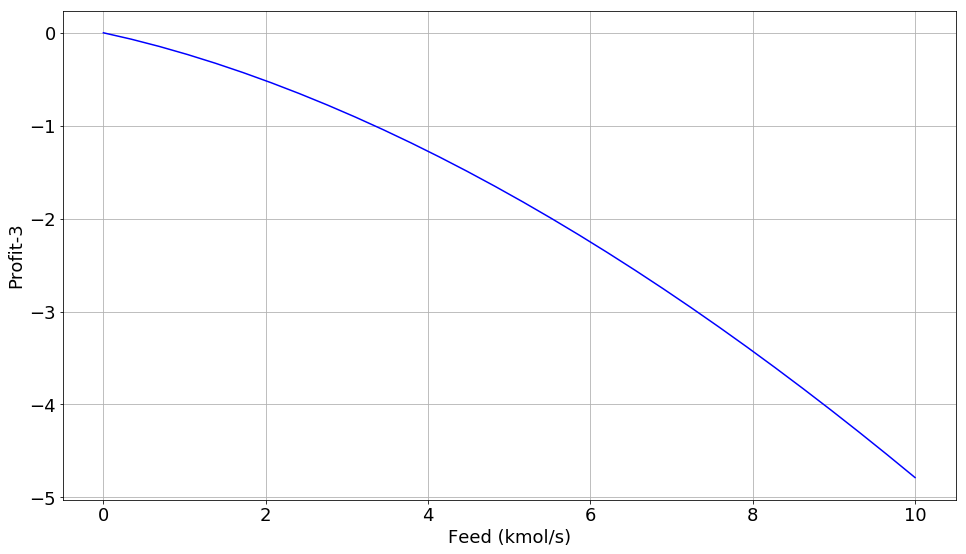

In [31]:
fig, ax = plt.subplots(figsize=(16,9))
line = ax.plot(F_range,Obj_list, 'b-')
ax.set_xlabel('Feed (kmol/s)',fontsize=18)
ax.set_ylabel('Profit-3',fontsize=18)
ax.tick_params('y',labelsize=18)
ax.tick_params('x',labelsize=18)
ax.grid()

plt.show()

In [32]:
# model.solutions.store_to(results)
# with open('../../saved_solutions/reactive_flash_MPCC_P_200C.pickle','wb') as f:
#     pickle.dump(results,f)

In [33]:
# with open('test_model.pickle','wb') as f:
#     dill.dump(model,f)